In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scikits.odes.ode import ode
import time
import seaborn as sns

In [38]:
#Import local functions
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

def loss_biological(j1, j2, alpha1, alpha2):
    """Computes scalarized loss including genetic constraint and product production"""
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss

In [23]:
def dual_control(t, y, ydot):
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

In [41]:
#Run for UR
def dual_control(t, y, ydot):
        kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
        ydot[3] = k2 - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = repression(y[1], k1, theta1, n1)

In [47]:
#Run for DA
def dual_control(t, y, ydot):
        kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = k1 - lam*y[2]
        ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = activation(y[1], k2, theta2, n2)

In [48]:
#Establish hyperparameters
alpha1 = 1E-5
alpha2 = 1E-2

int_time = 5E4
t = np.linspace(0, int_time, 100) 
y0 = np.array([2290., 0., 0., 0., 0., 0.]) 

#Constants
Vin = 1
e0 = 0.0467 
lam = 1.93E-4 
#Assume equal kinetics for all three enzymes
kc = 12 
km = 10


In [49]:
ns = [1, 2, 3, 4]
thetas = [0.01, 0.05, 0.1, 0.5, 1, 2.5, 5, 7.5, 10, 100]
ks = [1E-7, 5E-6, 1E-6, 5E-5, 1E-5, 5E-4, 1E-4, 1E-3, 1E-3]

In [50]:
def solve_point(x):
    n1, n2, theta1, theta2, k1, k2 = x
    solution = ode('cvode', dual_control, old_api=False).solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=alpha1, alpha2=alpha2)
    return j1, j2, loss

In [51]:
results = pd.DataFrame(columns=['n1', 'n2', 'theta1', 'theta2', 'k1', 'k2', 'elapsed_time', 'j1', 'j2', 'loss'])
for n1 in ns:
    for n2 in ns:
        for k1 in ks:
            for k2 in ks:
                for theta1 in thetas:
                    for theta2 in thetas:
                        start_time = time.time()
                        j1, j2, loss = solve_point([n1, n2, theta1, theta2, k1, k2])
                        elapsed_time = time.time()-start_time
                        row = [n1, n2, theta1, theta2, k1, k2, elapsed_time, j1, j2, loss]
                        results.loc[len(results)] = row

In [52]:
results.to_csv('da_landscape_sundials.csv')

<AxesSubplot:xlabel='loss', ylabel='Density'>

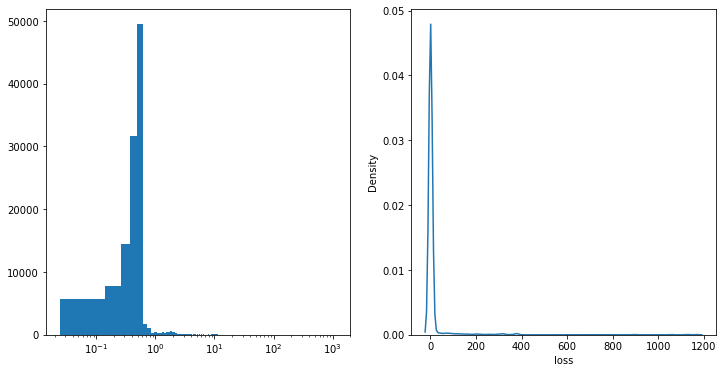

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
ax.hist(results.loss, bins=10000)
ax.set_xscale('log')

ax = axs[1]
sns.kdeplot(results.loss, ax=ax)


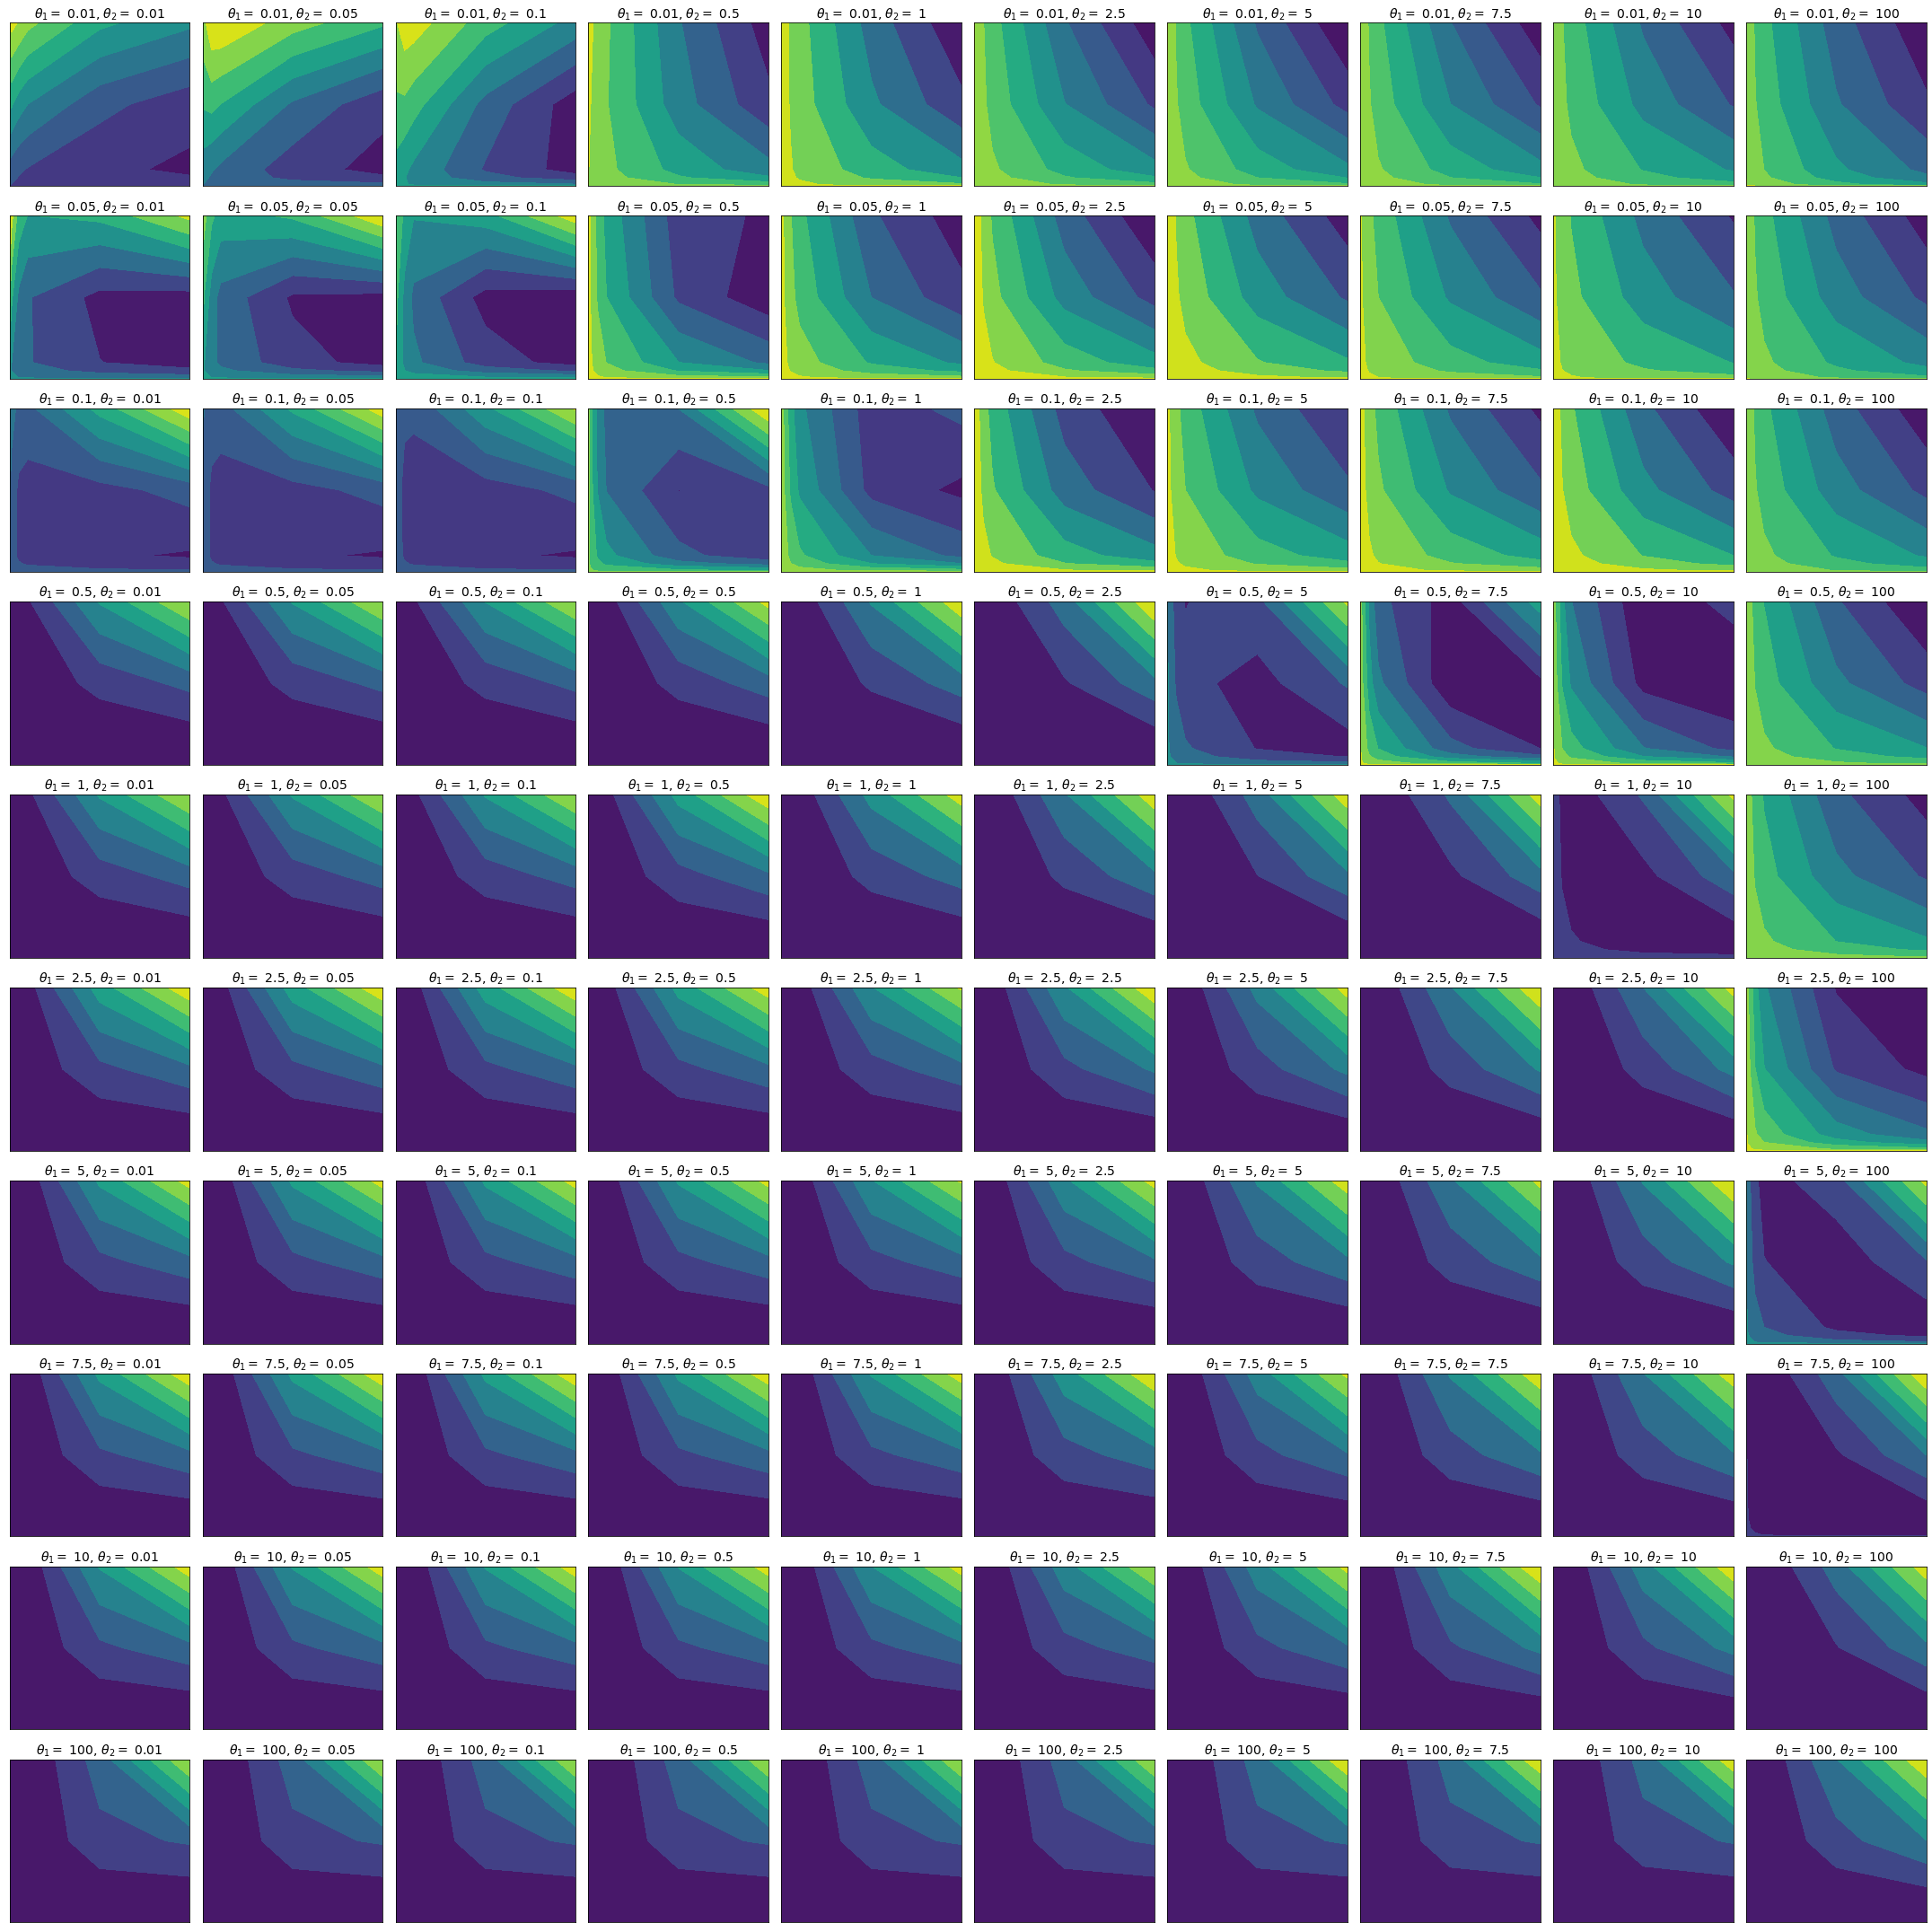

In [49]:
#Try to regenerate plots from solvers
doubles = results.loc[results.n1 == 2].loc[results.n2 == 2]

fig, axs = plt.subplots(10, 10, figsize=(30,30))

for i in range(10):
    for j in range(10):
        ax = axs[i][j]
        theta1 = thetas[i]
        theta2 = thetas[j]
        d = doubles.loc[doubles.theta1 == theta1].loc[doubles.theta2 ==theta2]
        k1_unique = np.sort(d.k1.unique())
        k2_unique = np.sort(d.k2.unique())
        k1s, k2s = np.meshgrid(k1_unique, k2_unique)
        loss = d.pivot_table(index='k1', columns='k2', values='loss').T.values
        contour = ax.contourf(k1s,k2s,loss)
        ax.set_title(rf'$\theta_1 = $ {round(theta1, 2)}, $\theta_2 = $ {round(theta2, 2)}', fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        #fig.colorbar(contour, ax=ax)

fig.tight_layout()

In [10]:
results = pd.read_csv('6d_landscape_sundials.csv')
results = results.loc[results.theta1 != 100].loc[results.theta2 != 100]

In [11]:
#PCA on loss landscape
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ['n1', 'n2', 'theta1', 'theta2', 'k1', 'k2']

x = results.loc[:, features].values
y = results.loc[:,['loss']].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
finalDf = pd.concat([principalDf, results[['loss']]], axis = 1)


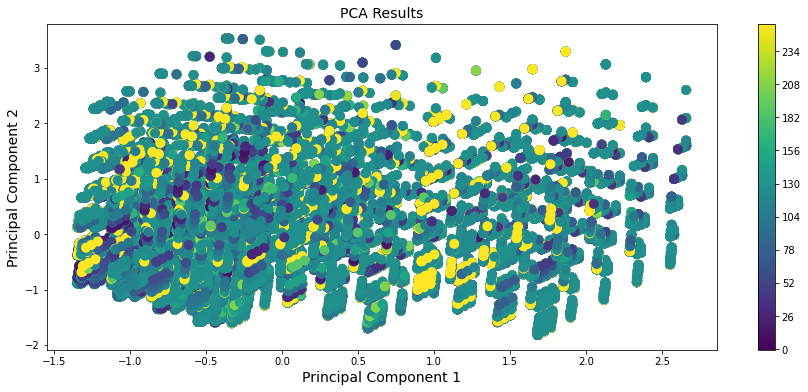

In [26]:
#Visualize PCA
import matplotlib
fig, axs = plt.subplots(1, 1, figsize=(15, 6))

endpoint = 'PCA Results'
ax = axs
#sns.scatterplot(x='pc1', y='pc2', data = finalDf, hue='loss', ax=ax)
plt.scatter(finalDf.pc1,finalDf.pc2,edgecolors='none',s=100,c=finalDf.loss,
                norm=matplotlib.colors.NoNorm())
plt.colorbar()
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
fig.savefig('PCA_results_nonorm.png')

In [27]:
#Run TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)

results['tsne-2d-one'] = tsne_results[:,0]
results['tsne-2d-two'] = tsne_results[:,1]

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 104976 samples in 0.064s...
[t-SNE] Computed neighbors for 104976 samples in 4.609s...
[t-SNE] Computed conditional probabilities for sample 1000 / 104976
[t-SNE] Computed conditional probabilities for sample 2000 / 104976
[t-SNE] Computed conditional probabilities for sample 3000 / 104976
[t-SNE] Computed conditional probabilities for sample 4000 / 104976
[t-SNE] Computed conditional probabilities for sample 5000 / 104976
[t-SNE] Computed conditional probabilities for sample 6000 / 104976
[t-SNE] Computed conditional probabilities for sample 7000 / 104976
[t-SNE] Computed conditional probabilities for sample 8000 / 104976
[t-SNE] Computed conditional probabilities for sample 9000 / 104976
[t-SNE] Computed conditional probabilities for sample 10000 / 104976
[t-SNE] Computed conditional probabilities for sample 11000 / 104976
[t-SNE] Computed conditional probabilities for sample 12000 / 104976
[t-SNE] Computed conditional probab

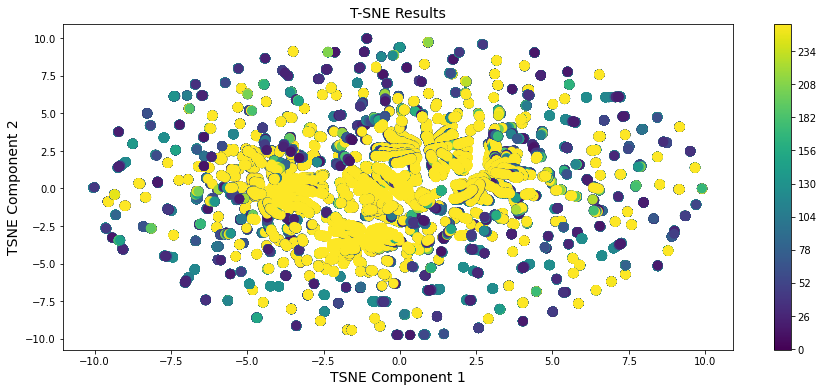

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(15, 6))

endpoint = 'T-SNE Results'
ax = axs
#sns.scatterplot(x='pc1', y='pc2', data = finalDf, hue='loss', ax=ax)
plt.scatter(results['tsne-2d-one'], results['tsne-2d-two'],edgecolors='none',s=100,c=results.loss,
                norm=matplotlib.colors.NoNorm())
plt.colorbar()
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)
fig.savefig('TSNE_results_nonorm.png')